# Classifying Models for County Mobility



### Imports
Import libraries and write settings here.

In [1]:
import sys

In [2]:
sys.setrecursionlimit(5000)

In [2]:
import seaborn as sns
%matplotlib inline


In [3]:
#!pip install --upgrade pandas

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling packages

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score, precision_recall_curve, classification_report
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import statsmodels as sm 
import pydotplus 
from inspect import signature

# Options for pandas
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

In [7]:
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
# import chart_studio.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# cf.set_config_file(theme='white')

## Modeling on Income Data Only
Decision Tree and Logistic Regression

### Setting up data

In [4]:
county_mobility = pd.read_pickle('../../data/02_intermediate/county_mobility_incomeOnly')

In [5]:
county_health = pd.read_pickle('../../data/02_intermediate/county_measures')

In [7]:
county_mobility.columns

Index(['County FIPS Code', 'County Name', 'Commuting Zone ID',
       'Commuting Zone Name ', 'State', 'Number of Children in Core Sample',
       'Rank-Rank Slope', 'Absolute Upward Mobility', 'Top 1% Income Share',
       'Interquartile Income Range', 'Gini', 'Teenage Birth Rate',
       'Share Between p25 and p75', 'Mean Parent Income', 'Mean Child Income',
       'Parent Income P25', 'Child Income P25', 'Median Parent Income',
       'Median Child Income', 'Parent Income P75', 'Child Income P75',
       'Parent Income P90', 'Child Income P90', 'Parent Income P99',
       'Child Income P99', 'rank_diff', 'Target'],
      dtype='object')

In [6]:
features = ['Top 1% Income Share','Interquartile Income Range', 'Median Parent Income']

In [7]:
X = county_mobility.dropna(subset=features, axis=0)[features]
y = county_mobility.dropna(subset=features, axis=0)[['Target']]

In [61]:
X.shape
y.shape

(2769, 3)

(2769, 1)

In [8]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5) 

#### SMOTE - Addressing Unbalanced Classes

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

ImportError: cannot import name '_UnstableArchMixin' from 'sklearn.base' (C:\Users\njohnson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py)

In [9]:
smote = SMOTE(random_state=42, sampling_strategy=1)

In [10]:
X_train.shape
X_test.shape

(831, 3)

In [16]:
X_res, y_res = smote.fit_resample(X_train, y_train) # np.array(y_train).ravel())

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
X_res.shape
y_res.shape
type(X_res)
type(y_res)

numpy.ndarray

### Decision Tree 1

In [18]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred)

0.8676293622141997

In [20]:
average_precision = average_precision_score(y_test, y_pred)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.23')

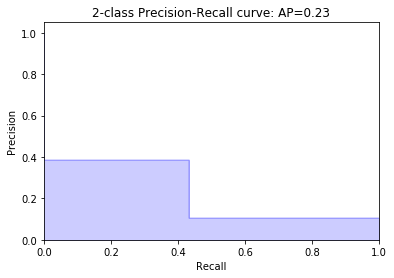

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [22]:
confusion_matrix(y_test, y_pred), average_precision_score(y_test, y_pred)


(array([[683,  60],
        [ 50,  38]]), 0.22760817487480717)

#### Decision Tree 1 Summary

Initial model exploration: 

 - Split data into 70:30 Train:Test
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Null values were dropped
 - Only specified `criterion='entropy'`
 
Results: 
 - Model accuracy was 0.866 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.23 (The ratio of correct positive predictions to the total predicted positives) (means I'm OVER predicting Mobility)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - run same data through logistic regression which will report the likelihood of being classified as Mobile based on the combination of features


### Decision Tree 2

Given unbalanced class, used SMOTE to resample the data. Now using X_res and y_res for fitting. 

In [14]:
# instantiating and fitting 2nd tree
clf_res = DecisionTreeClassifier(criterion='entropy', max_depth=2)
# 
# y_pred_res = clf_res.predict(X_test)

In [17]:
clf_res.fit(pd.DataFrame(X_res), pd.DataFrame(y_res))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
y_res_pred = clf_res.predict(X_test)

In [30]:
accuracy_score(y_test, y_res_pred)

0.7677496991576414

In [31]:
average_precision_score(y_test, y_res_pred)

0.23870742605731957

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.24')

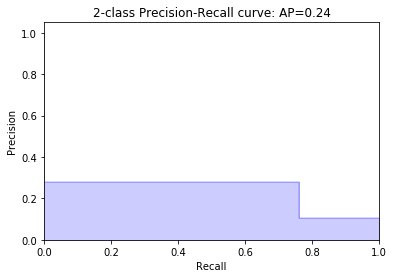

In [32]:
average_precision2 = average_precision_score(y_test, y_res_pred)
precision2, recall2, _ = precision_recall_curve(y_test, y_res_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall2, precision2, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall2, precision2, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision2))

#### Decision Tree 2 Summary

 - Used split data into 70:30 Train:Test (dropped nulls)
 - Did SMOTE on X_train, y_train
 - Only specified `criterion='entropy'`
 
Results: 
 - Model accuracy was 0.767 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.238 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - run same data through second logistic regression which will report the likelihood of being classified as Mobile based on the combination of features

### Logistic Regression 1

In [63]:
# Using sklearn first (but no p-values)
regr = LogisticRegression(C=1e5, solver='liblinear')

# train the model using the training sets
regr.fit(np.array(X_train), np.array(y_train).ravel())

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
prediction = regr.predict(X_test)

In [41]:
accuracy_score(y_test, predict)

0.8856799037304453

In [42]:
average_precision_score(y_test, prediction)

0.1698595390560801

In [50]:
# prob_X_test = []

# for 
# regr.predict_proba(X_test)[0][1] # probability that this county can be classified as Mobile based on the features

0.0035488980839694702

#### Logistic Regression Plotting

In [15]:
from scipy.special import expit

In [16]:
# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
#plt.scatter(np.array(X).ravel(), np.array(y).ravel(), color='black', zorder=20)

loss = np.array(expit(X_test * regr.coef_ + regr.intercept_)).ravel()
plt.scatter(np.array(X_test).ravel(), loss, color='red', linewidth=3)

# ols = linear_model.LinearRegression()
# ols.fit(X, y)
# plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
# plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
# plt.xticks(range(-5, 10))
# plt.yticks([0, 0.5, 1])
# plt.ylim(-.25, 1.25)
# plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

ValueError: Unable to coerce to Series, length must be 3: given 1

<Figure size 288x216 with 0 Axes>

In [17]:
# Variables needed for plotting the distribution: 

# store the coefficients
coef = regr.coef_
interc = regr.intercept_
# create the linear predictor
lin_pred= (X * coef + interc)
# perform the log transformation
mod_income = 1 / (1 + np.exp(-lin_pred))
# sort the numbers to make sure plot looks right
age_ordered, mod_income_ordered = zip(*sorted(zip(age ,mod_income.ravel()),key=lambda x: x[0]))

X, 

ValueError: Unable to coerce to Series, length must be 3: given 1

In [18]:
# Plotting the distribution

fig = plt.figure(figsize=(8,6))
fig.suptitle('logistic regression', fontsize=16)
plt.scatter(age, income_bin)
plt.xlabel("age", fontsize=14)
plt.ylabel("monthly income", fontsize=14)
plt.plot(age_ordered, mod_income_ordered, c = "black")
plt.show()

NameError: name 'age' is not defined

<Figure size 576x432 with 0 Axes>

#### Logistic Regression 1 Summary

Initial model exploration: 

 - Used same split data from decision tree: 
     - had to make the y_train a 1-d array
     - null values were dropped
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Only specified `C=1e5, solver='liblinear'`
 
Results: 
 - Model accuracy was 0.886 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.170 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - do SMOTE to addressed unbalanced classes


### Logistic Regression 2 - SMOTE vs. "balanced"

In [9]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr = LogisticRegression(C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr.fit(np.array(X_train), np.array(y_train).ravel())
prediction = regr.predict(X_test)
accuracy_score(y_test, prediction), average_precision_score(y_test, prediction)

(0.7713598074608905, 0.2482901556175473)

In [10]:
# Using SMOTE data instead of balanced classes, to compare the performance of SMOTE vs. the module's balancing
regr2 = LogisticRegression(C=1e5, solver='liblinear')

# train the model using the SMOTE-resampled training sets
regr2.fit(np.array(X_res), np.array(y_res).ravel())
y_res_pred2 = regr2.predict(X_test)
accuracy_score(y_test, y_res_pred2), average_precision_score(y_test, y_res_pred2)

NameError: name 'X_res' is not defined

#### Logistic Regression 2 Summary

Using 'balanced' class_weight in the Logistic Regression instance:

Accuracy Score = 0.771  
Precision = 0.248  

Using SMOTE data instead of balanced classes

Accuracy Score = 0.782  
Precision = 0.257  

## Modeling on County Income+Health Data merged
Decision Tree, Logistic Regression, Random Forest

### Bring in Data and Setup

In [19]:
county_imputed = pd.read_pickle('../../data/03_processed/county_merged_imputed')
county_dropped = pd.read_pickle('../../data/03_processed/county_merged_dropped_NaNs')

In [38]:
county_imputed.columns

Index(['County FIPS Code', 'County Name', 'Commuting Zone ID',
       'Commuting Zone Name ', 'State', 'Target', 'rank_diff',
       'Number of Children in Core Sample', 'Rank-Rank Slope',
       'Absolute Upward Mobility', 'Top 1% Income Share',
       'Interquartile Income Range', 'Share Between p25 and p75',
       'Mean Parent Income', 'Mean Child Income', 'Parent Income P25',
       'Child Income P25', 'Median Parent Income', 'Median Child Income',
       'Parent Income P75', 'Child Income P75', 'Parent Income P90',
       'Child Income P90', 'Parent Income P99', 'Child Income P99', 'Gini',
       'Teenage Birth Rate', 'Adult obesity', 'Children in poverty',
       'Daily fine particulate matter', 'Diabetic screening',
       'Mammography screening', 'Physical inactivity', 'Premature Death',
       'Preventable hospital stays', 'Sexually transmitted infections',
       'Unemployment', 'Uninsured', 'Violent crime rate'],
      dtype='object')

In [20]:
features_total = ['Top 1% Income Share', 'Interquartile Income Range',
                  'Share Between p25 and p75', 'Mean Parent Income', 'Parent Income P25',
                  'Median Parent Income', 'Parent Income P75',
                  'Parent Income P90', 'Parent Income P99',  'Teenage Birth Rate',
                  'Adult obesity', 'Children in poverty',
                  'Daily fine particulate matter', 'Diabetic screening',
                  'Mammography screening', 'Physical inactivity',
                  'Premature Death', 'Preventable hospital stays',
                  'Sexually transmitted infections', 'Unemployment',
                  'Uninsured', 'Violent crime rate']

In [21]:
X_drop = county_dropped[features_total]
y_drop = county_dropped[['Target']]

X_imp = county_imputed[features_total]
y_imp = county_imputed[['Target']]

In [22]:
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop,
                                                                        test_size=0.3,
                                                                        random_state=5)

In [23]:
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp, y_imp,
                                                                    test_size=0.3,
                                                                    random_state=5)

### Decision Trees

One for "Dropped NaNs" and one for "Imputed"

#### Tree for imputed

In [43]:
imp = DecisionTreeClassifier(criterion='entropy')
imp.fit(X_imp_train, y_imp_train)
y_imp_pred = imp.predict(X_imp_test)

In [48]:

average_precision_imp = average_precision_score(y_imp_test, y_imp_pred)
accuracy_score(y_imp_test, y_imp_pred), confusion_matrix(y_imp_test, y_imp_pred), average_precision_score(y_imp_test, y_imp_pred)

(0.9151643690349947, array([[797,  41],
        [ 39,  66]]), 0.4290743260366951)

#### Tree for Dropped 

In [45]:
drop = DecisionTreeClassifier(criterion='entropy')
drop.fit(X_drop_train, y_drop_train)
y_drop_pred = drop.predict(X_drop_test)

In [47]:

average_precision_drop = average_precision_score(y_imp_test, y_imp_pred)
accuracy_score(y_drop_test, y_drop_pred), confusion_matrix(y_drop_test, y_drop_pred), average_precision_score(y_drop_test, y_drop_pred)

(0.9058240396530359, array([[670,  51],
        [ 25,  61]]), 0.41729537950738343)

### Logistic Regressions

#### Logistic for Imputed

In [24]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr_imp = LogisticRegression(C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr_imp.fit(np.array(X_imp_train), np.array(y_imp_train).ravel())
prediction_imp = regr_imp.predict(X_imp_test)
accuracy_score(y_imp_test, prediction_imp), average_precision_score(y_imp_test, prediction_imp)

(0.8197242841993637, 0.3173556152575442)

#### Logistic for Dropped

In [25]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr_drop = LogisticRegression(C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr_drop.fit(np.array(X_drop_train), np.array(y_drop_train).ravel())
prediction_drop = regr_drop.predict(X_drop_test)
accuracy_score(y_drop_test, prediction_drop), average_precision_score(y_drop_test, prediction_drop)

(0.8104089219330854, 0.3271517614346157)

#### ROC Curves

Receiver Operator Characteristic curve (ROC curve) illustrates the true positive rate against false positive rate of our classifier.

Recall = the True Positive Rate.  the ratio of the true positive predictions compared to all values that are actually positive.

The ROC curve gives us a graph of the tradeoff between this false positive and true positive rate. The AUC, or area under the curve, gives us a singular metric to compare these. An AUC of 1 being a perfect classifier, and an AUC of .5 being that which has a precision of 50%.

##### Dropped Data

AUC is 0.9256201012805212


(0.0, 1.05)

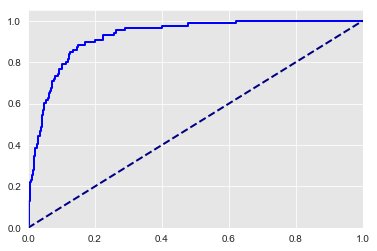

In [32]:
y_drop_score = regr_drop.fit(np.array(X_drop_train),
                             np.array(y_drop_train).ravel()).decision_function(X_drop_test)
fpr, tpr, thresholds = roc_curve(y_drop_test, y_drop_score)
auc(fpr, tpr)
print('AUC is {}'.format(auc(fpr, tpr)))
plt.plot(fpr, tpr, color='b',
             lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])



AUC: 0.9256201012805212


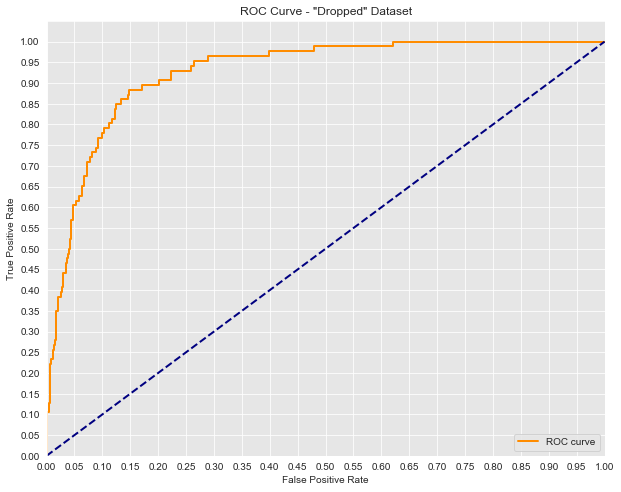

In [34]:
#Seaborns Beautiful Styling
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - "Dropped" Dataset')
plt.legend(loc="lower right")
plt.show()

##### Imputed Data

In [26]:
y_imp_score = regr_imp.fit(np.array(X_imp_train),
                             np.array(y_imp_train).ravel()).decision_function(X_imp_test)
fpr_imp, tpr_imp, thresholds_imp = roc_curve(y_imp_test, y_imp_score)
auc(fpr_imp, tpr_imp)


0.8976929196499602

AUC: 0.8976929196499602


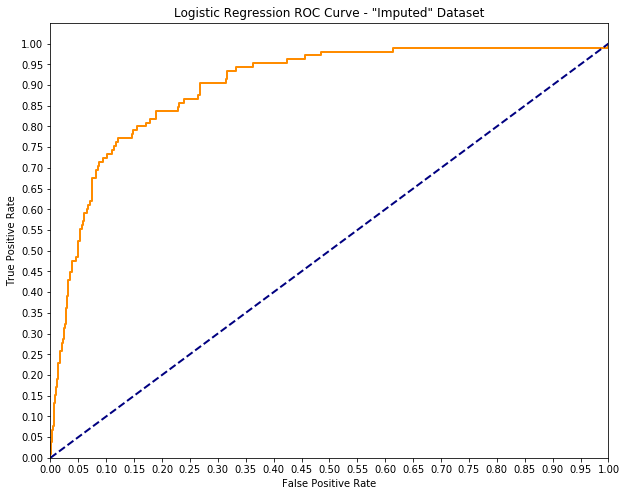

In [30]:
print('AUC: {}'.format(auc(fpr_imp, tpr_imp)))
plt.figure(figsize=(10,8))
lw=2
plt.plot(fpr_imp, tpr_imp, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve - "Imputed" Dataset')
plt.show()

In [35]:
print(classification_report(y_imp_test, prediction_imp, target_names=['Not Mobile', 'Mobile']))

              precision    recall  f1-score   support

  Not Mobile       0.97      0.82      0.89       838
      Mobile       0.36      0.82      0.50       105

   micro avg       0.82      0.82      0.82       943
   macro avg       0.67      0.82      0.70       943
weighted avg       0.91      0.82      0.85       943



### Random Forest

In [14]:
randFor = RandomForestClassifier(n_estimators=99, random_state=5)

randFor.fit(X_imp_train, y_imp_train)
rf_pred_train = randFor.predict(X_imp_train)
rf_pred_test = randFor.predict(X_imp_test)

rf_train_score = accuracy_score(y_imp_train, rf_pred_train)
rf_test_score = accuracy_score(y_imp_test, rf_pred_test)
print('Random Forest')
print("Training Accuracy: {:.2} \t\t Testing Accuracy: {:.2}".format(
    rf_train_score*100, rf_test_score*100))
print('Training Confusion Matrix\n', confusion_matrix(y_imp_train, rf_pred_train),
      '\n'+'-'*20+'\n',
      'Test Confusion Matrix\n', confusion_matrix(y_imp_test, rf_pred_test))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest
Training Accuracy: 1e+02 		 Testing Accuracy: 9.4e+01
Training Confusion Matrix
 [[1966    0]
 [   0  232]] 
--------------------
 Test Confusion Matrix
 [[827  11]
 [ 46  59]]


In [15]:
randFor = RandomForestClassifier(n_estimators=99, random_state=5, class_weight='balanced')

randFor.fit(X_imp_train, y_imp_train)
rf_pred_train = randFor.predict(X_imp_train)
rf_pred_test = randFor.predict(X_imp_test)

rf_train_score = accuracy_score(y_imp_train, rf_pred_train)
rf_test_score = accuracy_score(y_imp_test, rf_pred_test)
print('Random Forest')
print("Training Accuracy: {:.2} \t\t Testing Accuracy: {:.2}".format(rf_train_score*100, rf_test_score*100))
print('Training Confusion Matrix\n', confusion_matrix(y_imp_train, rf_pred_train), 
'\n'+'-'*20+'\n', 
'Test Confusion Matrix\n', confusion_matrix(y_imp_test, rf_pred_test))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest
Training Accuracy: 1e+02 		 Testing Accuracy: 9.4e+01
Training Confusion Matrix
 [[1966    0]
 [   0  232]] 
--------------------
 Test Confusion Matrix
 [[828  10]
 [ 50  55]]


In [23]:
print(classification_report(y_imp_test, rf_pred_test, target_names=['Not Mobile', 'Mobile']))

              precision    recall  f1-score   support

  Not Mobile       0.94      0.99      0.97       838
      Mobile       0.85      0.52      0.65       105

    accuracy                           0.94       943
   macro avg       0.89      0.76      0.81       943
weighted avg       0.93      0.94      0.93       943



### ROC Curves for RandomForest Classifier

In [21]:
randFor_ROC = randFor.fit(np.array(X_imp_train),
                             np.array(y_imp_train).ravel()).predict_proba(X_imp_test)
fpr_imp, tpr_imp, thresholds_imp = roc_curve(y_imp_test, randFor_ROC[:,1])
auc(fpr_imp, tpr_imp)

0.9561029662461643

AUC: 0.9561029662461643


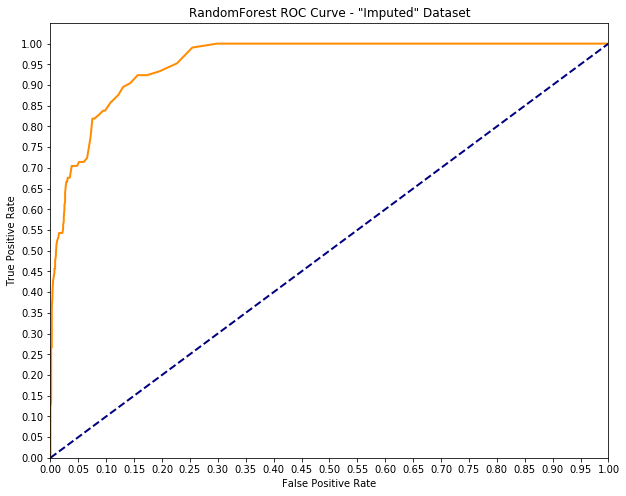

In [22]:
print('AUC: {}'.format(auc(fpr_imp, tpr_imp)))
plt.figure(figsize=(10,8))
lw=2
plt.plot(fpr_imp, tpr_imp, color='darkorange', lw=lw, label='RandomForest ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC Curve - "Imputed" Dataset')
plt.show()

## Getting Feature Importance

In [99]:
randFor.feature_importances_

array([0.01944416, 0.06974097, 0.16244581, 0.01682065, 0.07630195,
       0.01617481, 0.01665712, 0.02160343, 0.01928401, 0.13529357,
       0.0206655 , 0.05161591, 0.05215673, 0.02690396, 0.02376325,
       0.01810165, 0.04729636, 0.01562633, 0.02967136, 0.09897727,
       0.0276403 , 0.03381491])

In [107]:
from sklearn.tree import plot_tree
from operator import itemgetter

[('Preventable hospital stays', 0.015626334302003785), ('Median Parent Income', 0.016174813113475687), ('Parent Income P75', 0.016657116347674916), ('Mean Parent Income', 0.016820648285700582)] [('Unemployment', 0.09897727069799944), ('Teenage Birth Rate', 0.135293568860825), ('Share Between p25 and p75', 0.16244580665535233)]


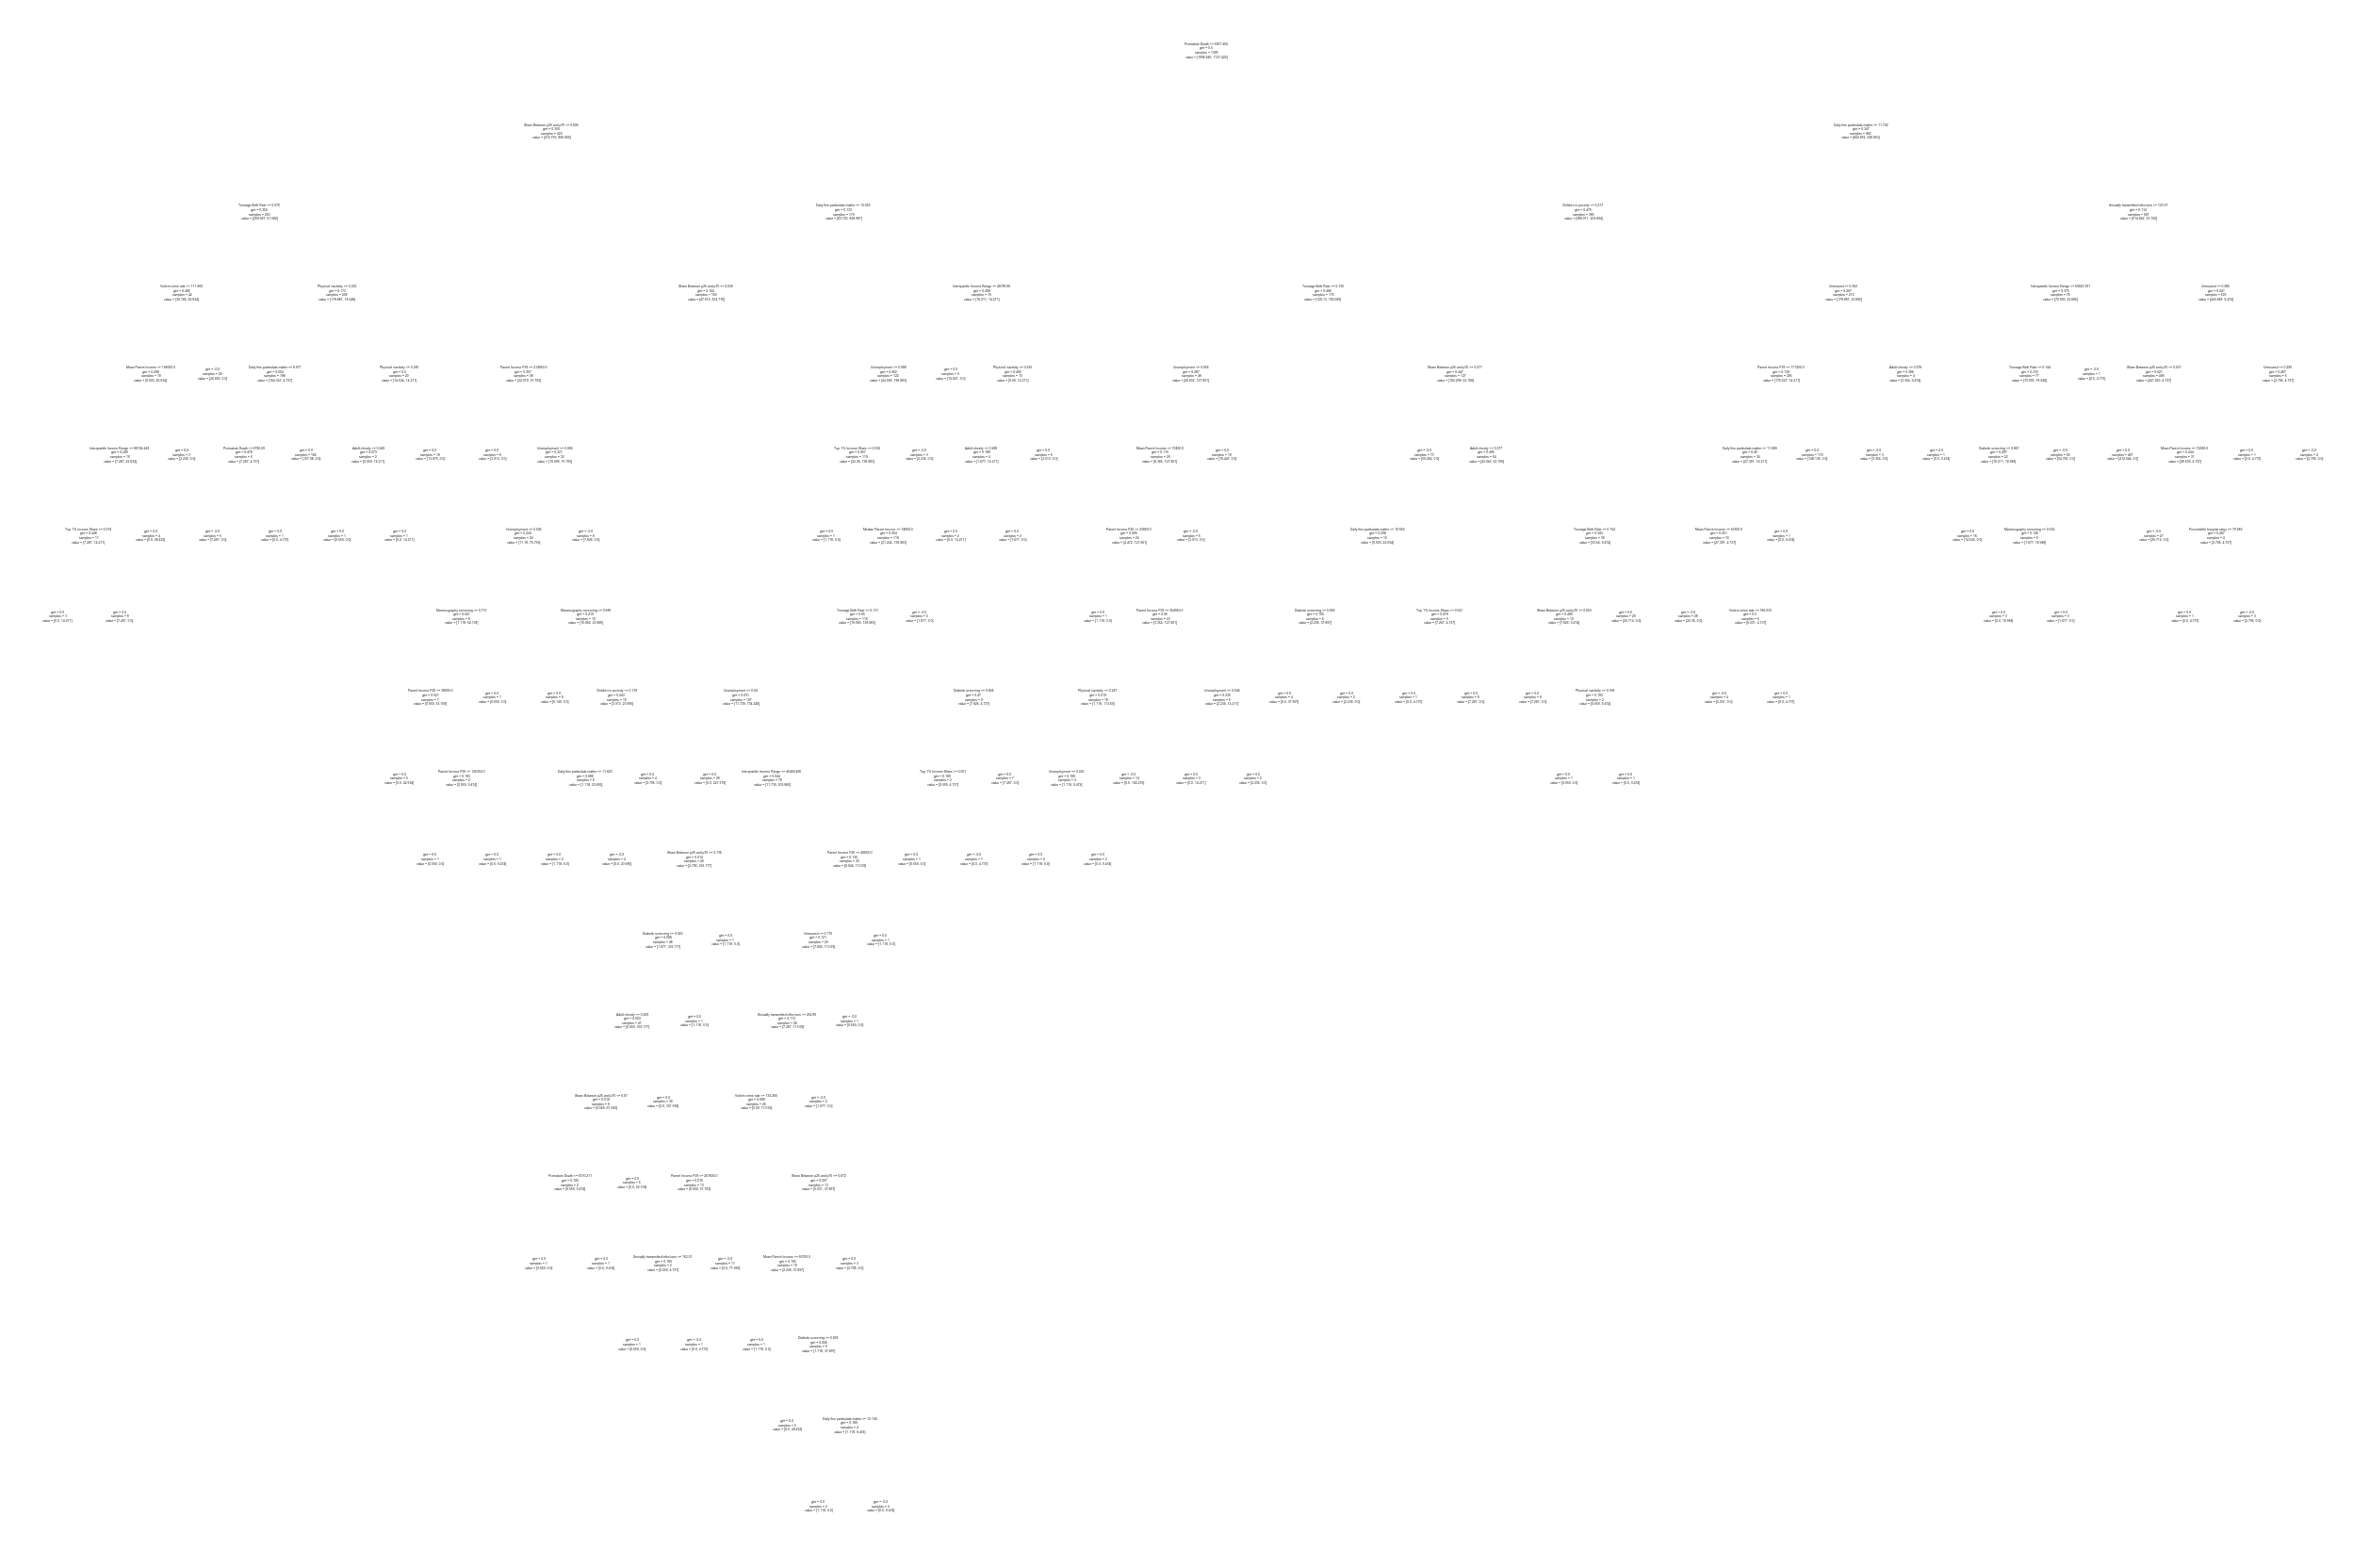

In [110]:
feature_names = X_imp_test.columns
rf_feature_importance = list(zip(feature_names, randFor.feature_importances_))
sorted_rf_feature_importance = sorted(rf_feature_importance, key=itemgetter(1))
print(sorted_rf_feature_importance[:4], sorted_rf_feature_importance[-3:])

fig = plt.figure(figsize=(44,30))
annotations = plot_tree(randFor[0], feature_names=feature_names)

## Confusion Matrix Pretty


Consider running Ridge and Lasso regressions to give indication of Feature Importance. Compare to Random Forest. 
 - need to scale data before doing Ridge and Lasso

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          size=(10, 6),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Parameters
    ----------
    y_true: list-like
        test/true values
    
    y_pred: list-like
        predicted values
        
    classes: list
        names of classes which predictions can fall into
        
    normalize: bool
        normalize the results (default False, do not normalize)
        
    title: str
        title of confusion matrix
        
    size: tuple (ordered pair)
        height and width in which the figure will display
        
    Returns
    -------
    ax: axis
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    #classes = class_names
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

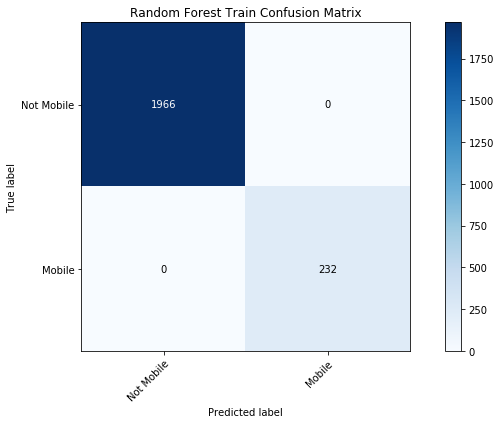

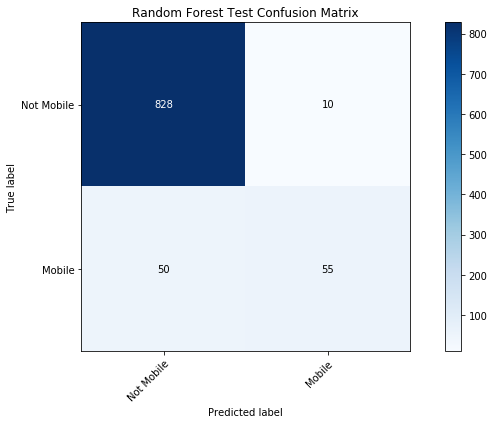

In [20]:
plot_confusion_matrix(y_imp_train, rf_pred_train, ['Not Mobile', 'Mobile'], title='Random Forest Train Confusion Matrix')
plt.show()
plot_confusion_matrix(y_imp_test, rf_pred_test, ['Not Mobile', 'Mobile'], title='Random Forest Test Confusion Matrix')
plt.show()

## Correlation Plots

In [116]:
county_imputed.columns  # testing pep8 ext

Index(['County FIPS Code', 'County Name', 'Commuting Zone ID',
       'Commuting Zone Name ', 'State', 'Target', 'rank_diff',
       'Number of Children in Core Sample', 'Rank-Rank Slope',
       'Absolute Upward Mobility', 'Top 1% Income Share',
       'Interquartile Income Range', 'Share Between p25 and p75',
       'Mean Parent Income', 'Mean Child Income', 'Parent Income P25',
       'Child Income P25', 'Median Parent Income', 'Median Child Income',
       'Parent Income P75', 'Child Income P75', 'Parent Income P90',
       'Child Income P90', 'Parent Income P99', 'Child Income P99', 'Gini',
       'Teenage Birth Rate', 'Adult obesity', 'Children in poverty',
       'Daily fine particulate matter', 'Diabetic screening',
       'Mammography screening', 'Physical inactivity', 'Premature Death',
       'Preventable hospital stays', 'Sexually transmitted infections',
       'Unemployment', 'Uninsured', 'Violent crime rate'],
      dtype='object')

In [ ]:
# removing outliers for scatter plot 

county_imputed.

Text(0.5, 1.0, 'Parent vs. Child Mean Income')

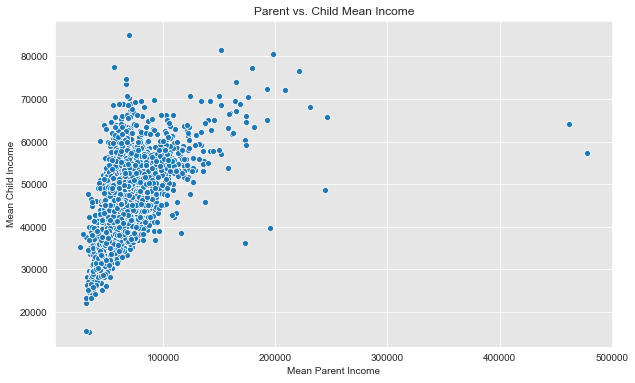

In [122]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x=county_imputed['Mean Parent Income'], y=county_imputed['Mean Child Income'])
plt.title('Parent vs. Child Mean Income')


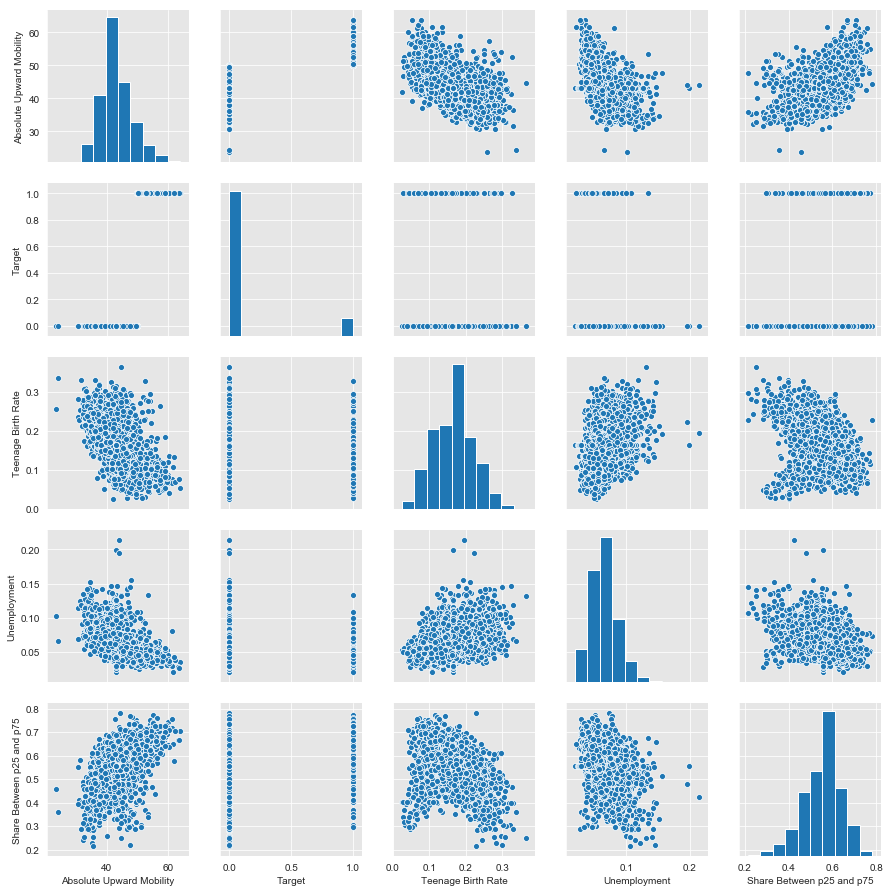

In [114]:
sns.pairplot(county_imputed[['Absolute Upward Mobility', 
                             'Target', 'Teenage Birth Rate', 
                             'Unemployment', 'Share Between p25 and p75']])

